# PeMS Data Analysis

This notebook combines PeMS traffic data from 2019-2025 and visualizes VMT trends.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path

## Load and Combine Data Files

Each year has two files:
- Regular file: VMT and Delay (V_t=60 or 40 depending on year)
- _40 file: Delay 40 and Productivity Loss 40

In [2]:
# Define the years we're loading
years = range(2019, 2026)
base_path = Path('.')

all_data = []

for year in years:
    # Load regular file (contains VMT)
    regular_file = base_path / f'pems_output{year}N.xlsx'
    df_regular = pd.read_excel(regular_file)
    
    # Load _40 file (contains Delay 40 and Productivity Loss 40)
    file_40 = base_path / f'pems_output{year}N_40.xlsx'
    df_40 = pd.read_excel(file_40)
    
    # Rename columns for consistency
    df_regular = df_regular.rename(columns={
        'VMT (Veh-Miles)': 'VMT',
        'Delay (V_t=60) (Veh-Hours)': 'Delay_60',
        'Delay (V_t=40) (Veh-Hours)': 'Delay_60',  # Some years use 40 threshold in regular file
        '# Lane Points': 'Lane_Points',
        '% Observed': 'Pct_Observed'
    })
    
    df_40 = df_40.rename(columns={
        'Delay (V_t=40) (Veh-Hours)': 'Delay_40',
        'Lost Prod (40) (lane-mi-hrs)': 'Productivity_Loss_40',
        '# Lane Points': 'Lane_Points',
        '% Observed': 'Pct_Observed'
    })
    
    # Merge on Month (and Lane_Points/Pct_Observed for verification)
    df_merged = df_regular[['Month', 'VMT', 'Delay_60', 'Lane_Points', 'Pct_Observed']].merge(
        df_40[['Month', 'Delay_40', 'Productivity_Loss_40']],
        on='Month',
        how='outer'
    )
    
    df_merged['Year'] = year
    all_data.append(df_merged)
    
# Combine all years
df = pd.concat(all_data, ignore_index=True)

# Ensure Month is datetime
df['Month'] = pd.to_datetime(df['Month'])

# Sort by date
df = df.sort_values('Month').reset_index(drop=True)

print(f"Combined dataset shape: {df.shape}")
df.head()

Combined dataset shape: (84, 8)


,Month,VMT,Delay_60,Lane_Points,Pct_Observed,Delay_40,Productivity_Loss_40,Year
0,2019-01-01,119138104.6,119805.2,4883190,73.8,119805.2,2318.0,2019
1,2019-02-01,109032563.1,115745.6,4418355,72.4,115745.6,2203.2,2019
2,2019-03-01,132266626.2,125220.0,4885434,75.9,125220.0,2517.5,2019
3,2019-04-01,122763147.4,136334.8,4732778,75.4,136334.8,2511.3,2019
4,2019-05-01,128112797.9,138170.0,4888035,71.5,138170.0,2445.4,2019


In [3]:
# View the complete dataset
df.info()
print("\n")
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Month                 84 non-null     datetime64[ns]
 1   VMT                   84 non-null     float64       
 2   Delay_60              84 non-null     float64       
 3   Lane_Points           84 non-null     int64         
 4   Pct_Observed          84 non-null     float64       
 5   Delay_40              84 non-null     float64       
 6   Productivity_Loss_40  84 non-null     float64       
 7   Year                  84 non-null     int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 5.4 KB




,Month,VMT,Delay_60,Lane_Points,Pct_Observed,Delay_40,Productivity_Loss_40,Year
count,84,8.400000e+01,84.000000,8.400000e+01,84.000000,84.000000,84.000000,84.000000
mean,2022-06-16 14:17:08.571428608,1.255921e+08,174781.586905,4.884846e+06,58.913095,104047.035714,1831.805952,2022.000000
min,2019-01-01 00:00:00,6.776629e+07,13218.100000,4.418355e+06,32.000000,13218.100000,209.100000,2019.000000
25%,2020-09-23 12:00:00,1.189327e+08,112954.250000,4.750056e+06,55.650000,58982.525000,1123.575000,2020.000000
50%,2022-06-16 00:00:00,1.277917e+08,160807.100000,4.900638e+06,59.050000,105255.650000,1851.150000,2022.000000
75%,2024-03-08 18:00:00,1.379875e+08,237120.175000,5.061399e+06,61.925000,134111.675000,2406.600000,2024.000000
max,2025-12-01 00:00:00,1.482757e+08,372857.800000,5.171280e+06,75.900000,240433.700000,3678.400000,2025.000000
std,NaN,1.519397e+07,89505.214788,1.656416e+05,7.446771,53980.379952,841.344062,2.012012


## VMT Histogram by Month (2019-2025)

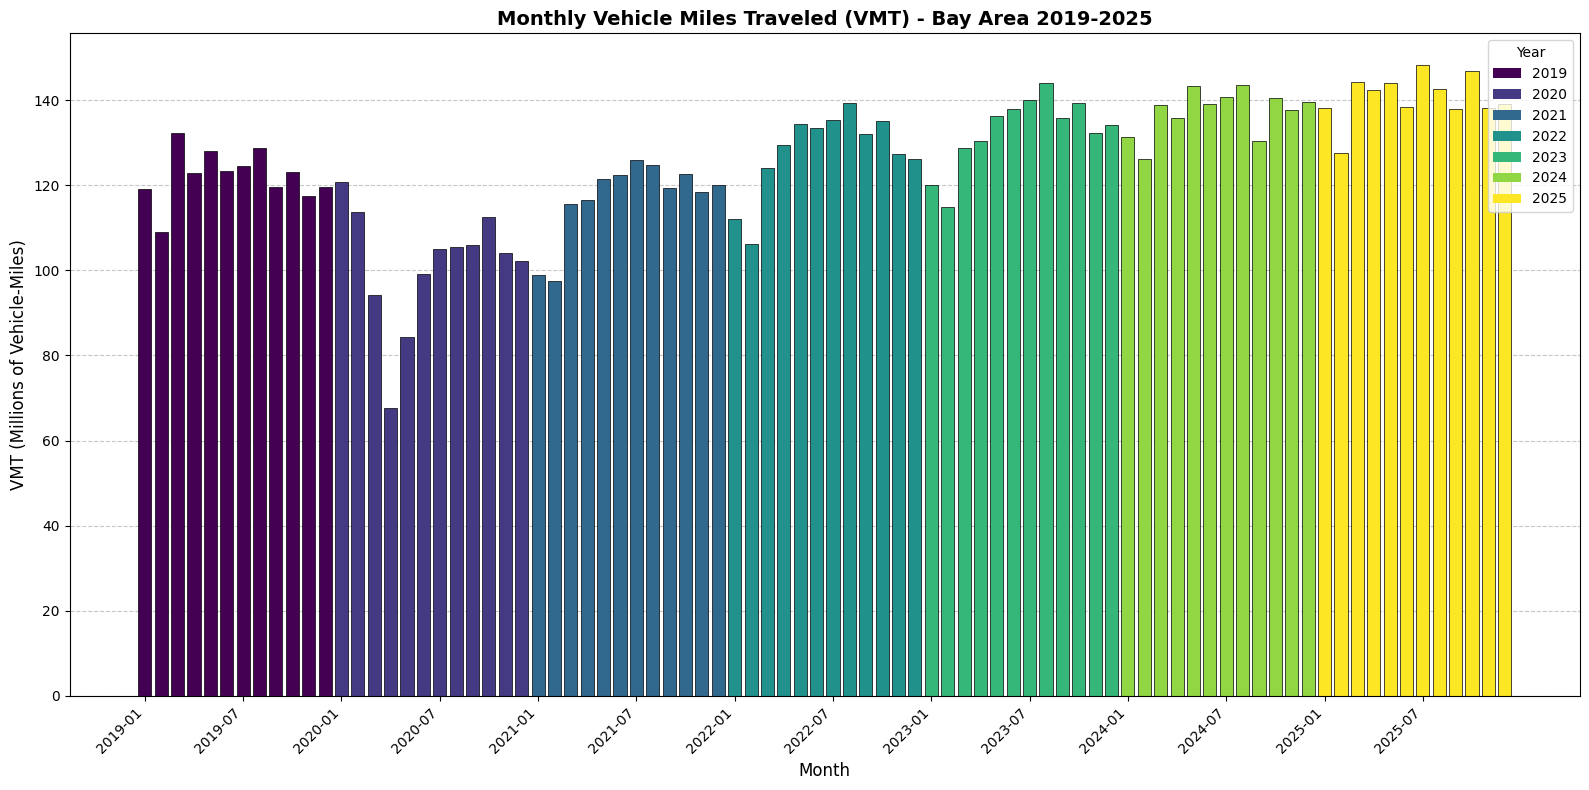

Chart saved as 'vmt_monthly_histogram.png'


In [4]:
# Create bar chart showing monthly VMT
fig, ax = plt.subplots(figsize=(16, 8))

# Create month labels
df['Month_Label'] = df['Month'].dt.strftime('%Y-%m')

# Create bar chart
bars = ax.bar(range(len(df)), df['VMT'] / 1e6, width=0.8, edgecolor='black', linewidth=0.5)

# Color bars by year
colors = plt.cm.viridis([i/6 for i in range(7)])
for i, bar in enumerate(bars):
    year_idx = df.iloc[i]['Year'] - 2019
    bar.set_facecolor(colors[year_idx])

# Set labels
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('VMT (Millions of Vehicle-Miles)', fontsize=12)
ax.set_title('Monthly Vehicle Miles Traveled (VMT) - Bay Area 2019-2025', fontsize=14, fontweight='bold')

# Set x-axis ticks (show every 6 months)
tick_positions = range(0, len(df), 6)
tick_labels = [df.iloc[i]['Month_Label'] for i in tick_positions]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45, ha='right')

# Add legend for years
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[i], label=str(2019+i)) for i in range(7)]
ax.legend(handles=legend_elements, title='Year', loc='upper right')

# Add gridlines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('vmt_monthly_histogram.png', dpi=150, bbox_inches='tight')
plt.show()

print("Chart saved as 'vmt_monthly_histogram.png'")

In [5]:
# Save the combined dataset
df.to_csv('pems_combined_data.csv', index=False)
print("Combined dataset saved as 'pems_combined_data.csv'")

Combined dataset saved as 'pems_combined_data.csv'


## Automated Data Retrieval with caltrans-pems Package

The [caltrans-pems](https://github.com/Seb-Good/caltrans-pems) package provides programmatic access to CalTrans PeMS data. Below is a mockup of how to use it.

In [ ]:
# ============================================================================
# MOCKUP: Using caltrans-pems package for automated data retrieval
# ============================================================================
# Installation: pip install git+https://github.com/Seb-Good/caltrans-pems.git
# Requirements: mechanize, beautifulsoup4, pandas, numpy
# ============================================================================

from pems.handler import PeMSHandler
import os

# -----------------------------------------------------------------------------
# 1. Initialize handler with PeMS credentials
# -----------------------------------------------------------------------------
# You need a free account at http://pems.dot.ca.gov
handler = PeMSHandler(
    username='your_pems_username',
    password='your_pems_password',
    debug=True  # Enable logging for troubleshooting
)

# -----------------------------------------------------------------------------
# 2. Explore available data types
# -----------------------------------------------------------------------------
# Get list of available file types (e.g., 'station_5min', 'station_hour', etc.)
file_types = handler.get_file_types()
print("Available file types:", file_types)

# Get available districts for a specific file type
# Bay Area districts: District 4 (SF Bay Area), District 3 (Sacramento area)
districts = handler.get_districts(file_type='station_hour')
print("Available districts:", districts)

# -----------------------------------------------------------------------------
# 3. Query available files for download
# -----------------------------------------------------------------------------
# Search for files matching criteria
# District 4 = San Francisco Bay Area
available_files = handler.get_files(
    file_type='station_hour',    # Hourly station data
    district_id='4',             # Bay Area
    years=[2019, 2020, 2021, 2022, 2023, 2024, 2025]
)

print(f"Found {len(available_files)} files available for download")
print(available_files.head())

# -----------------------------------------------------------------------------
# 4. Download files
# -----------------------------------------------------------------------------
# Set download directory
download_path = './pems_raw_data'
os.makedirs(download_path, exist_ok=True)

# Download files (automatically skips previously downloaded files)
handler.download_files(
    files=available_files,
    output_path=download_path
)

# -----------------------------------------------------------------------------
# 5. Example: Download specific data types for Bay Area analysis
# -----------------------------------------------------------------------------
# For traffic volume analysis, useful file types include:
#   - 'station_5min'  : 5-minute aggregated station data
#   - 'station_hour'  : Hourly aggregated station data  
#   - 'station_day'   : Daily aggregated station data
#   - 'station_meta'  : Station metadata (location, lanes, etc.)

# Download daily data for multiple years (more manageable file sizes)
for year in range(2019, 2026):
    daily_files = handler.get_files(
        file_type='station_day',
        district_id='4',  # Bay Area
        years=[year]
    )
    handler.download_files(
        files=daily_files,
        output_path=f'./pems_raw_data/daily/{year}'
    )
    print(f"Downloaded {year} daily data")

### CalTrans District Reference for Bay Area Analysis

| District | Region | Relevance to Project |
|----------|--------|---------------------|
| **4** | San Francisco Bay Area | Core Bay Area - tech company HQs |
| **3** | Sacramento / North | Includes I-80 corridor (Tracy, Fairfield commuters) |
| **10** | Stockton / Central Valley | Tracy, Manteca, Modesto - outer suburb commutes |
| **5** | San Luis Obispo / Central Coast | Less relevant |

**Key Corridors for Commuter Analysis:**
- I-680 (Tri-Valley / Dublin / Pleasanton)
- I-580 (Livermore / Tracy / Central Valley)
- I-880 (Oakland / Fremont / San Jose)
- I-80 (Bay Bridge / Richmond / Fairfield / Vacaville)
- US-101 (Peninsula / South Bay / Gilroy)

In [ ]:
# ============================================================================
# MOCKUP: Processing downloaded PeMS data for corridor-specific analysis
# ============================================================================

import pandas as pd
import glob

# -----------------------------------------------------------------------------
# 1. Load station metadata to identify corridor stations
# -----------------------------------------------------------------------------
# Station metadata includes location (lat/lon), freeway, direction, etc.
station_meta = pd.read_csv('./pems_raw_data/d04_text_meta_yyyy_mm_dd.txt', sep='\t')

# Filter to specific freeways of interest
# These corridors connect outer suburbs to Bay Area job centers
commuter_corridors = {
    'I-580': station_meta[station_meta['Fwy'] == 580],  # Livermore/Tracy
    'I-680': station_meta[station_meta['Fwy'] == 680],  # Tri-Valley
    'I-80':  station_meta[station_meta['Fwy'] == 80],   # East Bay / Fairfield
}

# Get station IDs for each corridor
corridor_stations = {}
for corridor, df in commuter_corridors.items():
    # Focus on westbound (toward SF/Oakland) morning commute direction
    westbound = df[df['Dir'].isin(['W', 'S'])]  # West or South toward city
    corridor_stations[corridor] = westbound['ID'].tolist()
    print(f"{corridor}: {len(westbound)} westbound stations")

# -----------------------------------------------------------------------------
# 2. Load and aggregate daily traffic data by corridor
# -----------------------------------------------------------------------------
def load_corridor_data(year, corridor_station_ids):
    """Load daily data and filter to specific station IDs."""
    files = glob.glob(f'./pems_raw_data/daily/{year}/*.txt')
    
    dfs = []
    for f in files:
        df = pd.read_csv(f, sep='\t')
        df = df[df['Station'].isin(corridor_station_ids)]
        dfs.append(df)
    
    return pd.concat(dfs, ignore_index=True)

# Load I-580 data (key Tracy/Central Valley commuter corridor)
i580_data = {}
for year in range(2019, 2026):
    i580_data[year] = load_corridor_data(year, corridor_stations['I-580'])
    print(f"Loaded {len(i580_data[year])} records for I-580 in {year}")

# -----------------------------------------------------------------------------
# 3. Calculate peak-hour metrics (6-9 AM westbound = commute direction)
# -----------------------------------------------------------------------------
# If using hourly data instead of daily:
def calculate_peak_hour_volume(hourly_df):
    """Extract 6-9 AM weekday traffic as proxy for commuter volume."""
    # Filter to weekdays only
    hourly_df['Date'] = pd.to_datetime(hourly_df['Timestamp']).dt.date
    hourly_df['Hour'] = pd.to_datetime(hourly_df['Timestamp']).dt.hour
    hourly_df['DayOfWeek'] = pd.to_datetime(hourly_df['Timestamp']).dt.dayofweek
    
    # Weekdays (Mon=0, Fri=4), morning peak (6-9 AM)
    peak = hourly_df[
        (hourly_df['DayOfWeek'] < 5) & 
        (hourly_df['Hour'] >= 6) & 
        (hourly_df['Hour'] < 9)
    ]
    
    # Aggregate by month
    peak['Month'] = pd.to_datetime(peak['Date']).dt.to_period('M')
    monthly_peak = peak.groupby('Month')['Flow'].sum().reset_index()
    monthly_peak.columns = ['Month', 'Peak_AM_Volume']
    
    return monthly_peak